#### Random Forest Model Over Sampling
- Uses ensemble of decision trees.
- Breaking whole bunch of decision trees and putting them together.
- Increases prediction accuracy  
PRO   
- Reduces over fitting - which may not be representative of true population
- Reduces Bias - i.e. not evenly split in training.

Need parameters:
- Node Size
- Number of Trees 
- Number of Features 

The number of estimators - number of decision trees used to build the ensemble model. 
In order for the sampling techniques to work best, you should previously perform any pre-processing steps you can. 

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline


In [2]:
####### OPTION 1 if NOT SAMPLING DATA
# READ IN CSV fraud_det_dig_df
fraud_df = pd.read_csv("../Resources/fraud_det_dig_df.csv")

In [ ]:
# ######## OPTION 2 for SAMPLING DATA
# ## Create additional step if SAMPLING only.
# ## READ IN CSV fraud_det_dig_df
# fraud_det_df = pd.read_csv("../Resources/fraud_det_dig_df.csv")
# fraud_det_df.head()


# ## Create Sample of data to work with
# # Determine the proportions of 'isFraud' values in the DataFrame
# fraud_proportions = fraud_det_df['isFraud'].value_counts(normalize=True)

# # Calculate the number of samples needed for each 'isFraud' value
# sample_size = 100000
# sample_per_is_fraud = (fraud_proportions * sample_size).astype(int)

# # Use the 'groupby' function to take a proportional sample
# fraud_df = fraud_det_df.groupby('isFraud').apply(lambda x: x.sample(sample_per_is_fraud[x.name]))

# # Reset the index of the sampled DataFrame
# fraud_df.reset_index(drop=True, inplace=True)
# fraud_df.head()

In [3]:
# Define target vector and features
y = fraud_df['isFraud'].values.reshape(-1, 1)
X = fraud_df.drop('isFraud', axis=1)


In [4]:
# Perform train-test split on the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Scaling Data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# UNDERSAMPLING using RandomUndersampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train.ravel())

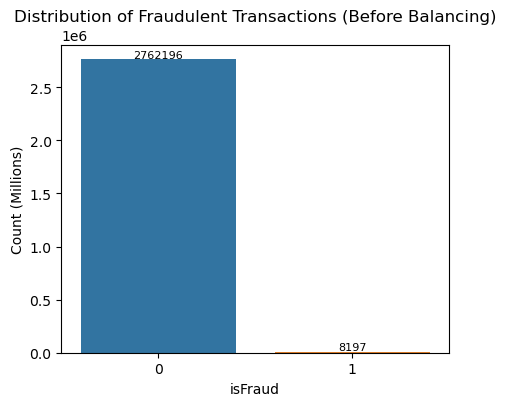

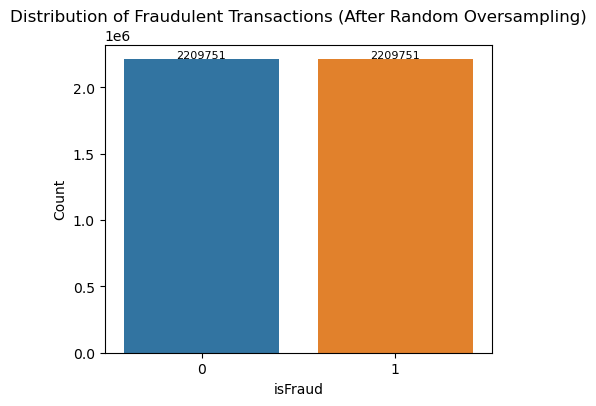

In [7]:
# VISUALISATION
# Visualize the distribution of 'isFraud' before balancing
plt.figure(figsize=(5, 4))  # Adjust the figsize to make the chart smaller
ax = sns.countplot(data=fraud_df, x='isFraud')

for p in ax.patches:
    count = p.get_height()
    ax.annotate(f"{count:.0f}", (p.get_x() + p.get_width() / 2., count), 
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (Before Balancing)")
plt.xlabel("isFraud")
plt.ylabel("Count (Millions)")
plt.show()

# Visualize the distribution of'isFraud' after Random Undersampling
plt.figure(figsize=(5, 4))
ax = sns.countplot(x=y_ros)

for p in ax.patches:
    count = p.get_height()
    ax.annotate(f"{count:.0f}", (p.get_x() + p.get_width() / 2., count), 
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (After Random Oversampling)")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

------------------------------------------
### Fitting the Random Forest Model
- Model 1
-----------------------------------------------


In [8]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [9]:
# Fit the model on the resampled data
rf_model.fit(X_ros, y_ros)

Making Preductions Using Random Forest Model

In [23]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)


Model1 Evaluation 

In [25]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [26]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,538596,13849
Actual 1,67,1567


Accuracy Score : 0.9748844478855904
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552445
           1       0.10      0.96      0.18      1634

    accuracy                           0.97    554079
   macro avg       0.55      0.97      0.59    554079
weighted avg       1.00      0.97      0.98    554079



#### Feature Importance

In [27]:
# Get the feature importance array
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.17708349192931583, 'newbalanceDest'),
 (0.15736324743131389, 'oldbalanceDest'),
 (0.13137850213232577, 'trans_weight'),
 (0.10592443364537235, 'oldbalanceOrg'),
 (0.09233013220193445, 'hour'),
 (0.07652944436605097, 'step'),
 (0.0688018072178962, 'amount'),
 (0.058105127352515135, 'day'),
 (0.03142870091912602, 'type_CASH_OUT'),
 (0.030062779388484298, 'type_TRANSFER')]

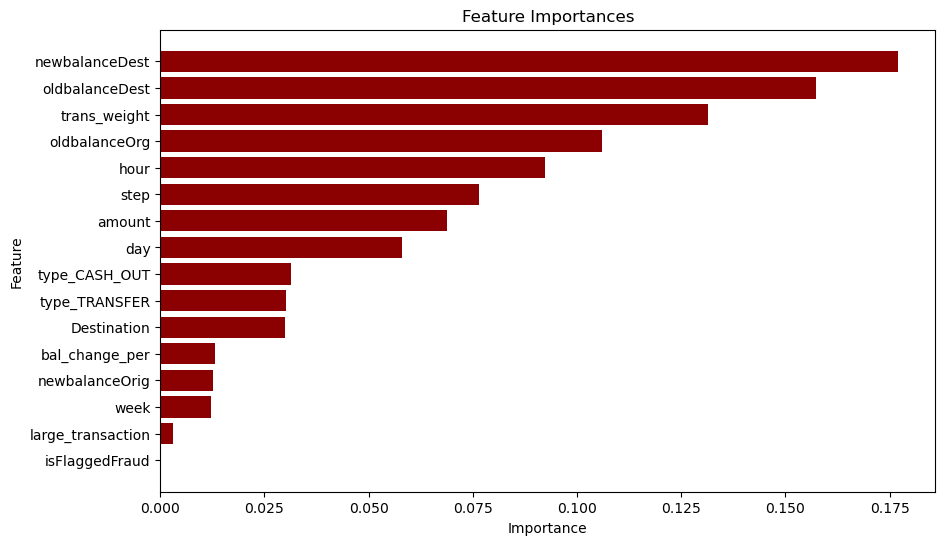

In [28]:
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})

# Sort the DataFrame by importance values in ascending order to rank features from top to bottom
importances_sorted = importances_df.sort_values(by='Importance')

# Plot the feature importances with dark red color scheme
plt.figure(figsize=(10, 6))
plt.barh(importances_sorted['Feature'], importances_sorted['Importance'], color='darkred')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
